In [2]:
##@title Install requirements
! pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install ipyplot
! pip install pytube
! pip install av

import ipyplot
import glob
import numpy as np
import os
import shutil

import av
import clip
import torch
from tqdm import tqdm
from PIL import Image
from pytube import YouTube

device = "cuda" if torch.cuda.is_available() else "cpu"

     |████████████████████████████████| 60.4 MB 18.3 MB/s            
     |████████████████████████████████| 292 kB 118.4 MB/s            
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-myjza283
  Running command git clone --filter=blob:none -q https://github.com/openai/CLIP.git /tmp/pip-req-build-myjza283
  Resolved https://github.com/openai/CLIP.git to commit 573315e83f07b53a61ff5098757e8fc885f1703e
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369094 sha256=daffbbb4efaef98b82148599cec2fe11572bd8d543f73fdbfb3a9fe23b9103ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-7gfslr6z/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip
  Using cached shortuuid-1.0.8-py3-none-any.whl (9.5 kB)
     |████████████████████████████████| 56 kB 1.9 MB/s             
     |████████████████████████████████| 36.6 MB 15.8 MB/s            


In [145]:
# Download video from youtube and save as frames.
# center: iCl8RgG_7yA
# https://youtu.be/XPhND-lEgk0

video_id = {'center': 'iCl8RgG_7yA', 'far': 'XPhND-lEgk0', 'right': 'T0kOwctZ4ic', 'left': 'hcvf1LuPQMs', 'front': '5nAIADv1XJw'}
_type = "far"
id = video_id[_type]
video_url = f'https://www.youtube.com/watch?v={id}'

streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="720p", only_video=True)
streams[0].download(filename="video.mp4")

frames = []
content = 'video.mp4'
with av.open(content) as container:
    stream = container.streams.video[0]
    stream.codec_context.skip_frame = 'NONKEY'

    for frame in container.decode(stream):
        img_pil = frame.to_image()
        frames.append(img_pil)
print(len(frames))

# Yolo Model to detect objects!
try:
    shutil.rmtree('./output')
except:
    pass
os.makedirs('./output')

3


In [146]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5x')
def detect(frames):
    for frame in tqdm(frames):
        try:
            results = model_yolo(frame)
            results.crop(save_dir='./output')
        except:
            pass
    return [Image.open(f).convert('RGB') for f in glob.glob('./output/crops/**/*.jpg')]

def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

Using cache found in /home/xin/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-10 torch 1.10.1 CUDA:0 (NVIDIA RTX A6000, 48685MiB)

Fusing layers... 
Model Summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [147]:
output_yolo = detect(frames)
# output_yolo_2 = detect(output_yolo_1)

  0%|          | 0/3 [00:00<?, ?it/s]Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

100%|██████████| 3/3 [00:00<00:00, 34.62it/s]


Detected total 31 objects
[   0.032562    0.031708    0.032471    0.031769    0.032623    0.031799    0.032288    0.032623    0.032074     0.03186    0.032074    0.032532    0.032074    0.033112    0.032898    0.032562    0.032959    0.030975    0.031342    0.032135    0.032715    0.032684    0.032867    0.032501    0.032776    0.032227
    0.032501    0.032318    0.031494    0.031403    0.031708]
0.03296


/home/xin/miniconda3/lib/python3.9/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



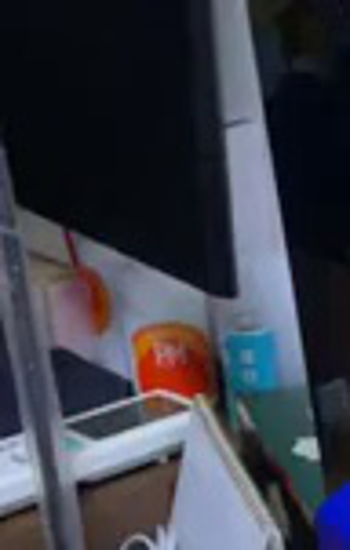


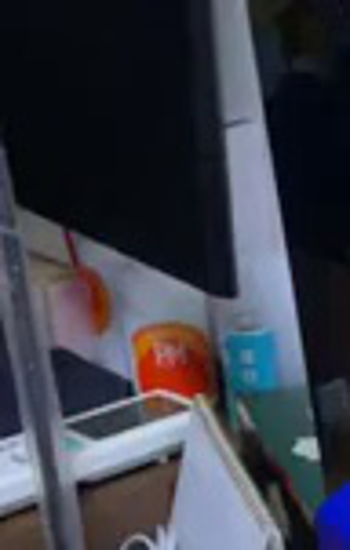

0.0331



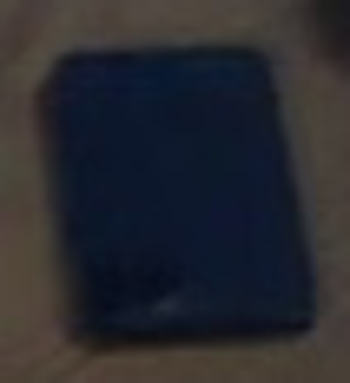


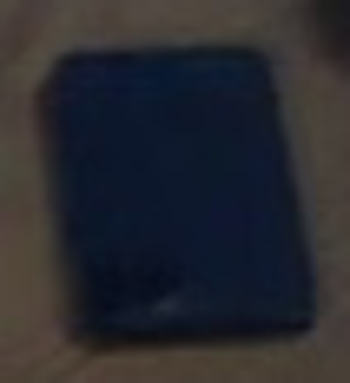

0.0329



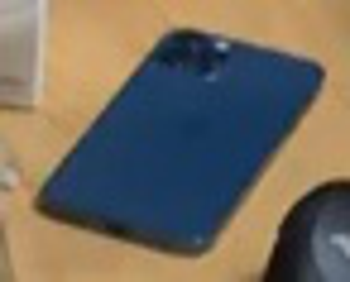


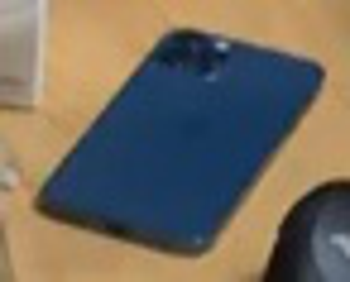

In [149]:
print(f'Detected total {len(output_yolo)} objects')
# CLIP to computer the prompt and crops.
model_clip, preprocess = clip.load("ViT-B/16", device=device)

prompt = "a mobile phone camera"
images = torch.stack([preprocess(image) for image in output_yolo]).to(device)

with torch.no_grad():
    image_features = model_clip.encode_image(images)
    text_encoded = model_clip.encode_text(clip.tokenize(prompt).to(device))

image_features /= image_features.norm(dim=-1, keepdim=True)
text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

similarity = text_encoded.cpu().numpy() @ image_features.cpu().numpy().T
similarity = softmax(similarity[0])
print(similarity)
top = 3
indexs = np.argpartition(-np.array(similarity), top)[:top]
for i in indexs:
    # print(similarity[i]/ sum(similarity))
    print(similarity[i])
    ipyplot.plot_images(output_yolo[i:i+1], img_width=350)